# Tool for Analyzing Twitter Tweet #GamerGate Case

There are different metholodies and tactics to analyze Twitter tweets. From topic modeling to sentiment analysis. Therefore it is imporant for researcher to have the ability to manipulate tweets to suit their needed. 

This IPython Notebook uses #GamerGate Tweets as the example data for analysis. It will cover aspects such as tokenization of text, extracting hashtags, graphing, LIWC, etc.

Note: The example data is already formatted into a CSV with all the information the IPython Notebook needs. These are the tweet text, time stamp of the tweet, and screen name.

# Import Libaries

Importing the required libaries for the projects. For installation instruction refer to the libaries home page. 

In [44]:
# Importing more generic libraries
import glob
import os
import math
import csv
import ast
from collections import Counter

# Importing data structure libraries
import pandas as pd
import numpy as np

# Import graphing tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

# Import text analysist tools
import re
import nltk
from nltk.tokenize import RegexpTokenizer

# Gathering the Required Information From Original Tweet CSV

The example CSV files contains a large amount of information about each tweet. From text to screen names. However we do not need all this information. For this porject we are just going to need a few of these categories. Therefore we are going to selectively import only certain categories. 

From there we are also going to do some additional formating. The reason for this is to streamline some analysis later on. For example we do not need to know the exact second, or hours of tweets. Therefore we can remove that extra information. 

Note: In this project I have chosen to extract all mentions and urls from the original text and replace them with "@MENTION" and "@LINK". This is to help streamline text anaylsis later on. However they are not deleted, just seperated into their own column.

Tokens are also capitalized to make anaylsis easier.

# Helper Functions For Loading / Saving Files

These are helper functions that help us load and save files. They each have their own use and applications. For more detail see their description in the code. 

Note: Some of the code references material that is not yet used or apparent early on. 

In [45]:
# Loading multiple files in a path
# This is used when all the files want to load are all together in a folder
def loading_multiple_file_path(path, colSelect, colNames, need_convert=None, column_convert=None):

    # Load all the files
    allFiles = glob.glob(path + "/*.csv")

    # Holds all the tweets
    dataframe = pd.DataFrame()

    # Holds the individual date tweets
    dataframe= []

    # Debugs to ensure the code is working
    print("Begin reading .csv in " + path + "....")
    
    # Check to see if some columns need to be converted back into a list object 
    if need_convert:
        
        # Create the function to convert to a list
        string_to_list = lambda x: ast.literal_eval(str(x))

        # Create the converter that will convert all the columns we tell it to back to a list object
        conv = {}
        for entry in column_convert:
            conv[entry] = string_to_list
        
        # Read every file
        for file_ in allFiles:

            # Debugs to ensure the code is working
            print("Reading and Converting file: " + str(file_) + "....")
            df = pd.read_csv(file_,  skiprows=1, usecols=colSelect, names=colNames)

            dataframe.append(df)
    else:
        # Read every file
        for file_ in allFiles:

            # Debugs to ensure the code is working
            print("Reading file: " + str(file_) + "....")
            df = read_frame
            df = pd.read_csv(file_,  skiprows=1, usecols=colSelect, names=colNames)

            dataframe.append(df)
    
    # Debugs to ensure the code is running
    print("Finished reading all files in " + path + "\n")
    
    print("Merge all individual file dataframes together into a single dataframe...")
    dataframe = pd.concat(dataframe)
    
    print("Finished merging all the files into a single dataframe" )
    
    return dataframe

# Save the dataframe
def save_frame(data_frame_name, name_of_file):
    
    print("Begin saving dataframe into a csv")
    
    name = name_of_file + ".csv"
    # Save the dataframe
    data_frame_name.to_csv(name, sep=',', encoding='utf-8')
    
    print("Finish and saved into " + name + "\n")

# Loads the dataframe. By default it skips the 1st column (this is usually the index) 
# for length it is amount of column + 1
def read_frame(csv_file_name, length=None, custom= False, colList = None, colNames = None):
    print("Reading csv " + csv_file_name)
    name = csv_file_name + ".csv"
    
    # Load csv by specifying which ones you want 
    if custom:
        return_frame = pd.read_csv(name,  usecols = colList)
    # Load csv by length skipping the first one (index)
    else: 
        return_frame = pd.read_csv(name,  usecols = range(1,length))
    print("Finish reading " + csv_file_name + "\n")
    return return_frame

# Similar to the one before except this converts the list present in the csv back into list objects to be used
def read_frame_convert_list (csv_file_name, columnNames, length=None, custom= False, colList = None):
    
    # Create the function to convert to a list
    string_to_list = lambda x: ast.literal_eval(str(x))

    # Create the converter that will convert all the columns we tell it to back to a list object
    conv = {}
    
    # Assign the converter for each column to convert
    for entry in columnNames:
        conv[entry] = string_to_list
    
    print("Reading csv " + csv_file_name)
    name = csv_file_name + ".csv"

    # Load a specified amount of columns from the csv
    if custom:
        return_frame = pd.read_csv(name,  usecols = colList,  converters=conv)
    
    # Load the csv based on length
    else: 
        return_frame = pd.read_csv(name,  usecols = range(1,length),  converters=conv)
    print("Finish reading " + csv_file_name + "\n")
    
    return return_frame

# Defining Format Functions

These functions below help with the extraction and formatting of different aspects of the tweet. This include extracting Links, formatting dates. 

Note: We save the extracted URLs and MENTIONs into a list. Although when we save this back into a csv it will not be a list object. Therefore we are going to need to convert it back, and in order to do that we need all the values in these columns in proper list format.

In [3]:
# Extract the links from a text
def extract_links(dataframe):
    
    # Regrex to extract all the links
    urls = re.findall(r"http\S+", dataframe['text'])
    
    # Replace the link with the placeholder @LINK
    dataframe['text'] = re.sub(r"http\S+", "@LINK", dataframe['text'])
    
    # Insert the URL into their own column
    if not urls:
        dataframe["URL"] = []
    else: 
        dataframe["URL"] = urls
    return dataframe
    
    
# Extract tweeter mentions in a text
def extract_mentions(dataframe):
    
    # Regrex to extract all the mentions
    mention = re.findall(r"@([A-Za-z0-9_]+)", dataframe['text'])
    
    # Replace the mention with the placeholder @MENTION
    dataframe['text'] = re.sub(r"@([A-Za-z0-9_]+)", "@MENTION", dataframe['text'])
    
    # Insert the mention into their own column
    if not mention:
        dataframe["MENTION"] = []
    else: 
        dataframe["MENTION"] = mention
    return dataframe

# Corrects the date the declared format   
def format_date(dataframe, column_name, time_format):
    
    print("Start formatting date ")
    
    # Convert the time to date-time object
    dataframe[column_name] = pd.to_datetime(dataframe[column_name])
    
    # Convert the time to the desired format
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.strftime(time_format))  
    
    print("Finish formatting date \n") 
    
    return dataframe

# Setting up #GamerGate Tweets

Now that we declared the functions we need we are going to load in the GamerGate tweets.

From the original CSV I will be using columns 1,2,4. These column contain the time_stamp of the tweet, text of the tweet, and screen name.

Note: The analysis do take a very LONG time depending on the size of the dataset. Therefore upon finishing I saved them into a csv. This is to ensure I can load them in later and use them. If any lines regarding "saving" dataframe is commented out, it is because I have already calculated the results. This also include other functions that run some form of algorthmns for the same reason.   

In [ ]:
# Start inital setup
MasterTweetFrame = loading_multiple_file_path("./Tweets", [1,2,4], ["time_stamp","text", "screen_name"])

print("Start extracting Mentions\n")

# Extract the mentions
MasterTweetFrame = MasterTweetFrame.apply(extract_mentions, axis=1)

print("End extracting Mentions\n")
print("Start extracting URL\n")

# Extract the URLS
MasterTweetFrame = MasterTweetFrame.apply(extract_links, axis=1)

print("End Extracting URL\n")

# Format the date to use have year, month, day
MasterTweetFrame = format_date(MasterTweetFrame, "time_stamp", "%Y-%m-%d")

In [ ]:
# See first 5 entry of MasterTweetFrame
MasterTweetFrame[:5]

# CheckPoint Save and Load (MasterTweetFrame)

Now that we finished formatting MasterTweetFrame, we are going to save it and load it back. 

Note: The reason we load it back right away to ensure it saved correctly. This can be verified by matching the first 5 entries printed before the save with those after.

In [ ]:
# Saving the dataframe and the name we want the csv to have
save_frame(MasterTweetFrame, "MasterTweetFrame")

# Loading the dataframe and the amount of columns it has
# The 6 denotes the amount of total columns (including index)
MasterTweetFrame = read_frame("MasterTweetFrame", 6)

# Check to see if we saved it correctly
MasterTweetFrame[:5]

# Basic Characteristic of Tweets

With a complete list of all the tweets formated and saved into a dataframe (MasterTweetFrame), it is time to look at some characteristics of it.

In [ ]:
# Find out how many unique exist in the dataset for each type
print("There are " + str(len(MasterTweetFrame.time_stamp)) + " tweets recorded in the dataset")
print("There are " + str(len(MasterTweetFrame.time_stamp.unique())) + " days recorded in the dataset")
print("There are " + str(len(MasterTweetFrame.screen_name.unique())) + " usernames in the dataset")
print("There are " + str(len(MasterTweetFrame.URL.unique())) + " URL in the dataset")
print("There are " + str(len(MasterTweetFrame.MENTION.unique())) + " mentions in the dataset")

# Tweet Basic Statistic

Now that we have a Master dataframe with the original formatted data. Now we are going to create a new dataframe to hold some Statistic about the Master dataframe.

Note: We are going groupby. This is a feature of dataframe to allow us to categorize based on a column. In this example we are going to use it on "time_stamp".

In [ ]:
# Create a new dataframe to hold the statistic and we are going to group them by day and count
TweetBasicStatistic = MasterTweetFrame.groupby("time_stamp").count()

# Rename the columns to reflect what we have done
TweetBasicStatistic.columns = ["text_count", "screen_name_count","URL_count","MENTION_count"]

# See how the first 5 entry in the dataframe look like
TweetBasicStatistic[:5]

# CheckPoint Save and Load (TweetBasicStatistic) 

We save and reload the dataframe to ensure the data is saved and we can reuse it.

Note. This is slightly a bit different than the MasterTweetFrame. This is because "time_stamp" is an index not a column in this dataframe. Therefore before we save we are going to make it a column and when we load return it back to being an index. The reason for this is because the function that loads from the csvs skips the index.

In [ ]:
# Convert the time_stamp back into a column
TweetBasicStatistic = TweetBasicStatistic.reset_index()

# Save the dataframe
save_frame(TweetBasicStatistic, "TweetBasicStatistic")
    
# Load the dataframe from csv
TweetBasicStatistic = read_frame("TweetBasicStatistic", 6)

# Convert the column time_stamp back to an index
TweetBasicStatistic = TweetBasicStatistic.set_index("time_stamp")

# Check to see if the top 5 entry are correct
TweetBasicStatistic[:5]

# Graphing Functions

Now that we have done some basic analysis of the text. It is time to create some functions that help us graph the results. Here we declare 2 extra parameter to save the graph if needed. These do not have to be used. There will be example of both chooisng to save the graph create and not choosing to.

Note: The titles are hard coded for the example dataset used. In order to change it simply change the line with "fig.suptitle" with a new title.

In [46]:
# Plot a column value over time 
def basic_plot_generator(column, date, dataframe, intervalValue = 1, saveImage=False, fileName = None):
    # Plot how many tweets there are over the whole duration
    fig,ax = plt.subplots()

    # Set title for the graph
    fig.suptitle("GamerGate " + column + " Over Time", fontsize="x-large")

    # Create subplot of Tweet Count over time using a 3 month interval
    ax.plot(pd.to_datetime(date), dataframe[column], label=column)

    # Set the interval to be the default 1 month 
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=intervalValue))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    
    # Calculate the average
    countMean = [dataframe[column].mean()]*len(pd.to_datetime(date))
    mean_line = ax.plot(pd.to_datetime(date),countMean, label='Average Overall Count', linestyle='--')

    # Create a legend for the subplot
    legend = ax.legend(loc='upper center', shadow=True)
    
    # Saving the Plot as an Image
    if saveImage:
        fig.savefig(fileName)
    
    # Show Plot
    plt.show()

# Plot different columns against eachother over time
def plot_compare_generator(column, date, dataframe, intervalValue = 1, saveImage=False, fileName = None):
    
    # Plot how many tweets there are over the whole duration
    fig,ax = plt.subplots()

    # Generate Title
    title = "Comparing GamerGate Sentiements: "

    for element in column:
        title = title + " " + element 
    
    title = title + " Over time"
    
    # Set title for the graph
    fig.suptitle(title, fontsize="x-large")
    
    for element in column:
        # Create subplot of Tweet Count over time using a 3 month interval
        ax.plot(pd.to_datetime(date), dataframe[element], label=element)
        
    # Set the interval to be default 1 month 
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=intervalValue))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    
    # Create a legend for the subplot
    legend = ax.legend(loc='upper center', shadow=True)
    
    # Saving the Plot as an Image
    if saveImage:
        fig.savefig(fileName)
    
    # Show Plot
    plt.show()

# Plotting TweetBasicStatistic

Now that we declared some graphing functions it is time to display them.

In [ ]:
# Plot each category as well as their corresponding averages
for columns in TweetBasicStatistic:
    # This is an example of not choosing to save the image
    basic_plot_generator(columns, TweetBasicStatistic.index, TweetBasicStatistic)

# Advance Analysis Helper Function

In order to have more indepth analysis we are going break up the text into 'tokens'. Therefore we are going to create a new dataframe that contained tokened sentences and words and their respective count. This is done using nltk.

In [ ]:
# Calculate sentence length
def tokenize_text(dataframe):
    # Calculate number of sentences
    sentence = nltk.sent_tokenize(dataframe["text"]) 
    dataframe['sentence'] = sentence
    dataframe['num_sentence'] = len(sentence)
    
    # Calculate length of sentences
    sentence_length = []
    tokens = []
    for line in sentence:
        # Set tokenizer to reconize words + the shorthand @MENTION and @LINK
        tokenizer = RegexpTokenizer(r'\w+|@[A-Za-z0-9_-]*')
        words = tokenizer.tokenize(line)
        
        # Add the amount of tokens to the list 
        tokens = tokens + words
        sentence_length.append(len(words))

    # Calculate average sentence length
    dataframe['average_sentence_length'] = math.ceil(sum(sentence_length)/len(sentence_length))
        
    # Save Tokenized text
    dataframe['tokens'] = tokens
    
    # Save Token Count
    dataframe['count_tokens'] = len(tokens)
    
    return dataframe

# Token DataFrame

We will now create a new dataframe to hold all the tokenized values. To do this we first copy over all the columns that matter from MasterTweetFrame.

In [ ]:
# Copy the columns we want into new dataframe
TokenTweetFrame = MasterTweetFrame[['time_stamp','text']].copy()

# Advance Analysis Segmentation

Given that some dataset can be very large and the amount of time it takes to run an algorthmn over such as large dataset. It is important to have the ability to break larger dataset into smaller chuncks. Although this does not neccessarily speed up the process, it allows us to insert debugs to track our progress. It also allows us to restart from a segement if there is a crash rather than restart from the top. 

It is also during this time we are going to save completed chunks into a csv. This is to ensure our progress is not lost. This is not too big of a problem because we have declared a function that can read multiple files. 

Note: This function can be expanded upon easily. All that is needed is to add another condition in the for loop with a new algorithm and another number.

In [ ]:
# Section off the tweets into smaller chuncks and save it into csv
def create_save_section(size, Frame, Filename, algorithm, savedirectory):
    
    if not os.path.exists(savedirectory):
        os.makedirs(savedirectory)
    
    # Divide the dataframe into smaller chunk to work with
    # Set size of each chunk
    n = size

    #Create a list of the frame section
    FrameList = [Frame[i:i+n] for i in range(0,Frame.shape[0],n)]
    
    # Iterate through each section in the list
    for section in range(0,len(FrameList)):
        
        # Use the corresponding algorithm
        if algorithm == 1:
            # Print debug and run calculate sentence length
            print("Looking at section: " + str(section+1))
            newFrame = FrameList[section].apply(tokenize_text, axis=1)
            print("Finish looking at section: " + str(section+1))
        
        if algorithm == 2:
            # Print debug and run calculate sentence length
            print("Looking at section: " + str(section+1))
            newFrame = FrameList[section].apply(extract_hashtag, axis=1)
            print("Finish looking at section: " + str(section+1))
            
        if algorithm == 3:
            # Print debug and run calculate sentence length
            print("Looking at section: " + str(section+1))
            newFrame = FrameList[section].apply(update_values_category, axis=1)
            print("Finish looking at section: " + str(section+1))
        
        # Create the name of the save location based on file and directory
        saveLocation = "./" + savedirectory + "/" + Filename 
        
        # Print debug and save the section into a csv
        print("Saving the section: " + str(section+1) + " into csv")
        newFrame.to_csv(saveLocation + "_" + str(section+1) + ".csv", sep=',', encoding='utf-8')
        print("Finish saving into " + saveLocation + "_" + str(section+1) + ".csv")
    
    print("Finised saving all the files into " + saveLocation)

# Saving Loading the Segmented Tokenized Tweet Files

Now it is time to load back the tokenized tweet dataframe. Depending on the size of the dataset, this may take a large amount of time. Therefore it is important to incrementally save out work.

Note: The helper function "create_save_section" does not return us a dataframe to use. It just saves the files away. After it is processed and saved we just to have to load it back in. 

In [47]:
# Tokenize and Save the Tweets (each section has 10000 entries) 
# Algorthmn 1 for sentence length
#create_save_section(10000, TokenTweetFrame, "TokenTweet", 1, "Tweets_Tokenize")

# Loading the csvs into a dataframe
# Since all the csv are located in "Tweets_Tokenize we can just load from there
TokenTweetFrame = loading_multiple_file_path("./Tweets_Tokenize", [1,2,3,4,5,6,7], ["time_stamp","text","sentence","num_sentence","average_sentence_length","tokens","count_tokens"])
TokenTweetFrame

Begin reading .csv in ./Tweets_Tokenize....
Reading file: ./Tweets_Tokenize/TokenTweet_5.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_3.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_11.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_12.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_8.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_6.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_1.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_13.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_4.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_7.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_14.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_10.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_9.csv....
Reading file: ./Tweets_Tokenize/TokenTweet_2.csv....
Finished reading all files in ./Tweets_Tokenize

Merge all individual file dataframes together into a single dataframe...
Finished merging all the files into a single dataframe


,time_stamp,text,sentence,num_sentence,average_sentence_length,tokens,count_tokens
0,2015-09-21,beginning to see why the left and writers for...,['beginning to see why the left and writers f...,2,7,"['beginning', 'to', 'see', 'why', 'the', 'left...",NaN
1,2015-09-21,#Gamergate we need to man up against the fake ...,['#Gamergate we need to man up against the fak...,2,8,"['Gamergate', 'we', 'need', 'to', 'man', 'up',...",NaN
2,2015-09-21,"So really, #GamerGate if someone fancies thems...","['So really, #GamerGate if someone fancies the...",1,16,"['So', 'really', 'GamerGate', 'if', 'someone',...",NaN
3,2015-09-21,#Gamergate So we're not just fighting corrupti...,"[""#Gamergate So we're not just fighting corrup...",2,8,"['Gamergate', 'So', 'we', 're', 'not', 'just',...",NaN
4,2015-09-21,LETS JUST GIVE ALL PEDOS A BABY AND LET THEM F...,['LETS JUST GIVE ALL PEDOS A BABY AND LET THEM...,2,10,"['LETS', 'JUST', 'GIVE', 'ALL', 'PEDOS', 'A', ...",NaN
5,2015-09-21,Just finished recording the new video on #Game...,"[""Just finished recording the new video on #Ga...",1,26,"['Just', 'finished', 'recording', 'the', 'new'...",NaN
6,2015-09-21,I think I get why Anti #GamerGate groups like ...,"[""I think I get why Anti #GamerGate groups lik...",1,25,"['I', 'think', 'I', 'get', 'why', 'Anti', 'Gam...",NaN
7,2015-09-21,I think if #GamerGate plays it's cards right i...,"[""I think if #GamerGate plays it's cards right...",1,20,"['I', 'think', 'if', 'GamerGate', 'plays', 'it...",NaN
8,2015-09-21,.@MENTION We are fighting the corruption withi...,"['.', '@MENTION We are fighting the corruption...",3,7,"['@MENTION', 'We', 'are', 'fighting', 'the', '...",NaN
9,2015-09-21,@MENTION So even handed. You will have to acce...,"['@MENTION So even handed.', 'You will have to...",3,8,"['@MENTION', 'So', 'even', 'handed', 'You', 'w...",NaN


# Looking at TokenTweets

Now that we have the dataframe loaded it is time to look and see what it look like.

In [ ]:
# Look at the first 5 entries of TokenTweet
TokenTweetFrame[:5]

In [ ]:
# Find out how many unique exist in the dataset
print("There is an average of " + str(TokenTweetFrame["num_sentence"].mean()) + " sentences in the dataset")
print("The overall average sentence length per tweet is " + str(TokenTweetFrame["average_sentence_length"].mean()))

# Graphing Token Tweet

Now we are going to graph both the number of tweets and the average sentence length over time. First we need to set the index back to the time_stamp

In [ ]:
# Convert the column time_stamp back to an index
TokenTweetFrame = TokenTweetFrame.set_index("time_stamp")

# Resort the index (This is because we read from Mulitple Files)
TokenTweetFrame.sort_index(inplace=True)

# Calculating Overall Averages

Although we have number of sentences and average sentence length for each tweet, we want the average of these statistic for each day. Therefore we are going to create a new dataframe with these values to use. We will also include in this new dataframe the number of words in the tweets.

In [ ]:
# Calculate average on num_sentence, averaege_sentence_length and group by time_stamp
TokenGraphFrame = TokenTweetFrame[['num_sentence','average_sentence_length','count_tokens']].copy()

# Calculate average per day and save them into their own dataframe for graphing
TokenGraphFrame = TokenGraphFrame[['num_sentence','average_sentence_length','count_tokens']].groupby(["time_stamp"]).mean()

In [ ]:
# See what the first 5 entry look likes of token graph
TokenGraphFrame[:5]

In [ ]:
# Using the graph function we made we will plot these averages
for columns in TokenGraphFrame[["num_sentence", "average_sentence_length","count_tokens"]]:
    basic_plot_generator(columns, TokenGraphFrame.index, TokenGraphFrame)

# CheckPoint Save and Load (TokenGraphFrame) 

Now that we calculated some basic stylistic on the tweets we are going to save it into a csv for later use.

In [ ]:
# Convert the time_stamp into a column
TokenGraphFrame = TokenGraphFrame.reset_index()

# Save the dataframe
save_frame(TokenGraphFrame, "TokenGraphFrame")
    
# Load the dataframe from csv
TokenGraphFrame = read_frame("TokenGraphFrame", 5)

# Convert the column time_stamp back to an index
TokenGraphFrame = TokenGraphFrame.set_index("time_stamp")

# Looking at HASHTAGS

Now that we went over some basic statistic and stylistic. We are going to have a closer look at HASHTAGS. To do so we will extract all the hashtags and some other useful information. First we are going to need to create a new dataframe with the time and the tweet text. 

Note: We are removing the #gamergate from analysis. This is because all tweets gathered had this hashtag, therefore we want to know all the other hashtags used and how many there were of them.

In [5]:
# Extract out the hashtags and count how many there are
def extract_hashtag(dataframe):
    
    # Finds all the hashtags with regrex
    hashtag = re.findall(r"#(\w+)", dataframe["text"].upper())

    # Remove all instances GAMERGATE hashtag (since all tweets has it)
    # This includes duplicates
    while "GAMERGATE" in hashtag:
        hashtag.remove("GAMERGATE")

    # Insert hashtag and count into dataframe
    if hashtag:
        dataframe['HASHTAG'] = hashtag
        dataframe['count_hashtag'] = len(hashtag)
    else:
        dataframe['HASHTAG'] = []
        dataframe['count_hashtag'] = 0
        
    return dataframe

# Hashtag Statistics

Now that we have the function to extract hashtags from the text. However depending on the dataset this may take a while. Therefore it is safer to do the calculation in parts. 

Note: All hashtags are recorded in capitals. This is to streamline some calculation and analysis later on when we examine the occurance of each hashtag.

In [ ]:
# Create new dataframe with information we need from MasterTweetFrame
#HashtagStatisticFrame = MasterTweetFrame[['time_stamp','text']].copy()

# Create sections using the extract hashtag
#create_save_section(10000,HashtagStatisticFrame , "HashtagStatistic", 2, "Hashtag_Stat")

# Load back the csv (Note the files are saved in a folder)
HashtagStatisticFrame = loading_multiple_file_path("./Hashtag_Stat", [1,2,3,4], ["time_stamp","text","HASHTAG","count_hashtag"])

# Convert the column time_stamp to an index
HashtagStatisticFrame = HashtagStatisticFrame.set_index("time_stamp")

Begin reading .csv in ./Hashtag_Stat....
Reading file: ./Hashtag_Stat/HashtagStatistic_6.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_1.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_14.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_11.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_12.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_7.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_9.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_4.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_13.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_8.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_3.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_5.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_2.csv....
Reading file: ./Hashtag_Stat/HashtagStatistic_10.csv....
Finished reading all files in ./Hashtag_Stat


# Plotting Hashtag Graph

Now we are going to plot the average amount of hashtag use over time.

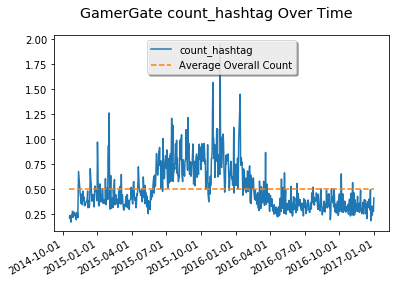

In [10]:
# Using the graph function we made we will plot these averages
HashtagGraphFrame = HashtagStatisticFrame.groupby(["time_stamp"]).mean()

for columns in HashtagGraphFrame[["count_hashtag"]]:
    basic_plot_generator(columns, HashtagGraphFrame.index, HashtagGraphFrame, intervalValue=3)

In [12]:
HashtagStatisticFrame

,text,HASHTAG,count_hashtag
time_stamp,,,
2014-10-21,Oh my goodness gracious. Here’s a dude who is ...,NaN,0
2014-10-21,&gt;Try to reach out to anti-#GamerGate time a...,NaN,0
2014-10-21,RT @MENTION: What is #Gamergate? And should yo...,NaN,0
2014-10-21,.@MENTION the salt is infinite. The SALT IS RE...,NaN,0
2014-10-21,"The more they try to say they aren't corrupt, ...",NaN,0
2014-10-21,@MENTION He'ss trying to click bait. He's been...,NaN,0
2014-10-21,"""Everyone whose life &amp; work I've always ad...",NaN,0
2014-10-21,@MENTION @MENTION #GamerGate history on IBTime...,NaN,0
2014-10-21,@MENTION I have no problem with the idea of a ...,NaN,0


# Most Popular Hashtag

Now that we have the hashtags in a dataframe, lets create a dateframe that looks into how popular a hashtag might be.

# Popular Hashtag Helper Function

We are going to declare a helper function that helps find the most popular hashtag

In [13]:
# Helper function that calculates what hashtag appear the most
def get_max_word(dataframe):
    
    # Calculates what is most popular
    popular = max(set(dataframe["HASHTAG"]), key=dataframe["HASHTAG"].count)
    
    # Assigns the values
    dataframe["most_popular"] = popular
    
    return dataframe

# HashtagPopularFrame

This is done by first collapsing the dates together and combining the hashtag list. Afterwards count how many of each hashtag are there.

In [18]:
# Create a new dataframe with just HASHTAG and count
HashtagPopularFrame = HashtagStatisticFrame[["HASHTAG","count_hashtag"]].copy()

# Unset time_stamp to save
HashtagPopularFrame = HashtagPopularFrame.reset_index()

HashtagPopularFrame = HashtagPopularFrame.fillna("[]")

# Save Frame
save_frame(HashtagPopularFrame, "HashtagPopularFrame")

# Load back the Frame except run it under the covnerter to get a list not object
#HashtagPopularFrame = read_frame_convert_list("HashtagPopularFrame", ["HASHTAG"], length = 4)

# Reset index back to date
#HashtagPopularFrame = HashtagPopularFrame.set_index("time_stamp")

# Collapsing the dataframe Hashtags and Count
#HashtagPopularFrame = HashtagPopularFrame[["HASHTAG","count_hashtag"]].groupby('time_stamp').agg({'HASHTAG': 'sum', 'count_hashtag': 'sum'})

# See what the first 5 results looks like
HashtagPopularFrame[:5]

Begin saving dataframe into a csv
Finish and saved into HashtagPopularFrame.csv



,time_stamp,HASHTAG,count_hashtag
0,2014-10-21,[],0
1,2014-10-21,[],0
2,2014-10-21,[],0
3,2014-10-21,[],0
4,2014-10-21,[],0


# Finding the Most popular Hashtag

Before we look into the most popular Hashtag we can collapse all the HASHTAGS in one date together and get the count. Then afterwards find the most popular hashtag in each date and see how it does over the whole period.

In [ ]:
# Now lets save the top most popular word by day into their own column
HashtagPopularFrame = HashtagPopularFrame.apply(lambda x: get_max_word(x), axis = 1)

# Reset Index
HashtagPopularFrame = HashtagPopularFrame.reset_index()

# Save Frame
save_frame(HashtagPopularFrame, "HashtagPopularFrame")

# Load back the Frame except run it under the covnerter to get a list not object
HashtagPopularFrame = read_frame_convert_list("HashtagPopularFrame", ["HASHTAG"], length = 5)

# Set Index
HashtagPopularFrame = HashtagPopularFrame.set_index("time_stamp")

# Print out the first 5 entry
HashtagPopularFrame[:5]

# Graphing the Occurance of Hashtag

Using the information gathered from HashtagPopularFrame we can see that "NOTYOURSHIELD" seems to be a popular hashtag. Therefore lets see how popular it was over time. To do this we will first create a new column for it. Therefore we we want to see more hashtags over time we can just run the algorthmn agian with a different hashtag.

# Occurance of Hashtag Helper Function

Declare helper functions to count occurance of hashtags.

In [ ]:
# Counts the occurance of a word
def countOccurance(dateframe, word):
    # Count the amount of hashtag in the list
    count = Counter(dateframe["HASHTAG"])
    title = "count_" + word
    dateframe[title] = count[word]
    return dateframe

# Calculating Occurance of "NOTYOURSHIELD"

Now we are going to count the occurnace of NOTYOURSHIELD

In [ ]:
# Acquire count of "NOTYOURSHIELD"
HashtagPopularFrame = HashtagPopularFrame.apply(lambda x: countOccurance(x, "NOTYOURSHIELD"), axis = 1)

# Show the first 5
HashtagPopularFrame[:5]

# Graphing the HASHTAG

Now that we had occurance of "NOTYOURSHIELD" we are going to graph it over time.

In [ ]:
# Using the graph function we made we will plot these averages
for columns in HashtagPopularFrame[["count_NOTYOURSHIELD"]]:
    # Example of saving the file
    basic_plot_generator(columns, HashtagPopularFrame.index, HashtagPopularFrame, saveImage=True, fileName="count_NOTYOURSHIELD")

# LIWC (Lingustic Inquiry Word Count) Analysis

We have looked at both Hashtags, word count, and other factors. Now we are going to look at LIWC analysis. This type of analysis pairs words with different categories (Postive, Negative, etc) and counts how many time a text fits into them. 

This requires a dictionary of words and categories. This can be found here 
http://www.wjh.harvard.edu/~inquirer/spreadsheet_guide.htm

With the dictionary and the token count (or word count) we can divide the number found in a particular category and the total token count of the tweet to get a percentage.

Note: I collapsed some of the aspects of the spreadsheet. This is because in the original there are multiple definition of a word. I have choosen to treat the all instances of the same word as the same and fused together their related categories. 

Therefore I have only kept the categories and nothing else.

# Loading the Words and Categories

First we are going to load the csv files (provided at the site above) and convert it to a dictionary. This allows us to do a much faster search on the list to fill a dataframe later on. 

In [48]:
# The csv name of the inquirer dictionary
csvFile = "inquirerbasic.csv"

# Create a list of rows to hold the values
listOfRows = []

# Reading the csv 
with open(csvFile, 'r') as file: # This makes sure that file is closed after reading
    data = csv.reader(file)
    
    # For every row in the fie save it
    for row in data:
        listOfRows.append(row)

# Close the file
file.closed

# Format the category
categories = listOfRows[0]

# We do not need the first 2 category (they have the word, and the source of it)
# The last two columns are description of the words in question. We also do not need that
# Note the csv also as additional 4 empty columns at the end (that is why we have -6)
categories = categories[2:len(categories)-6]

# Check on how many categories
print("Length of category " + str(len(categories)))

# Print out the first 5 categories
print(categories[:5])

Length of category 182
['Positiv', 'Negativ', 'Pstv', 'Affil', 'Ngtv']


# LIWC Helper Functions

Functions that help conduct LIWC. For more details see the code below for indivdual function use.

In [49]:
# Set all the categories of a word into a set if that word did not exist already
def new_attribute_set(row):
    # The reason for a set because it is faster to laod
    attributeSet = set()
    
    # If you belong to a category add it into the set
    for element in row:
        if element != "":
            attributeSet.add(element)
    return attributeSet;

# Combine with pre-existing set with any new additions
def combine_attribute_set(row, oldset):
    # The reason for a set because it is faster to laod
    newSet = set()
    
    # If you belong to a category add it into the set
    for element in row:
        if element != "":
            newSet.add(element)
    
    # Return a new updated set
    return (oldset | newSet)

# Assign every word with the categories (in a set)
def get_dictionary_list(listOfRows,categories):
    returnDict = {}

    # For every row create the set of categories that belong to it
    for row in listOfRows:
        
        # Reduce the word to the base. This is because the csv has LOVE#1, LOVE#2 to symbolize different meanings
        # In this anaylsis we can going to collapse them together
        word = row[0].split("#", 1)[0]
    
        # Check to see if the word is in the dictionary already
        if word in returnDict:
            returnDict[word] = combine_attribute_set(row[2:len(categories)-2], returnDict[word])
        else:
            returnDict[word] = new_attribute_set(row[2:len(categories)-2])
        
    return returnDict

# Creates the columns we need and fills them with how many of each categories the text belongs to
def update_values_category(dataframe):
    # Finds and counts all the categories it belongs to
    resultDictionary = find_category(dataframe["tokens"])
    # Iterate through the results
    for k, v in resultDictionary.items():
        # Create columns for every category
        dataframe[k] = v
    return dataframe

# Looks through the tokens and increments the appropriate categories that it belongs to
def find_category(tokens):
    # Set all categories to 0 as default
    tweetCategories = {el:0 for el in categories}
    # Iterate through all tokens
    for element in tokens:
        # If it exist increment the value
        if element.upper() in dictWords:
            inside = dictWords[element.upper()]
    
            # Increment the category
            for element in inside:
                tweetCategories[element] += 1
    
    return tweetCategories

# Creating the Dictionary

Now we are going to need a dictionary for the categories. This is done using the helper functions.

In [ ]:
# Copy the 3 columns we need
# Note since TokenTweetFrame had "time_stamp" as an index we are going to need to reset it before
# we can copy it over
CategoryTweetFrame = TokenTweetFrame.reset_index()[['time_stamp','tokens','count_tokens']].copy()

# Saving the file away
save_frame(CategoryTweetFrame, "CategoryTweetFrame")

# Read the csv using the made function that deals with converting and covert "tokens" column
CategoryTweetFrame = read_frame_convert_list("CategoryTweetFrame", ['tokens'], length=4)

# Set index 
CategoryTweetFrame = CategoryTweetFrame.set_index("time_stamp")

# See first 5 entries
CategoryTweetFrame[:5]

In [ ]:
# Create dictionary of words and their respective categories
dictWords = get_dictionary_list(listOfRows[1:], categories)

# Have a look at the dictionary
dictWords

# Creating the Catgories Dataframe

Now that we have the categories we can now move onto creating aa new dataframe that has all these categories listed. To do so we will be copying over a few columns from TokenTweetFrame (we do not need all of it).

Important note. When you are loading the csv into a panda it does not load the exact object type back. For example we saved 'tokens' as a list. However when we load it back it is not in that exact type. Therefore one method to do this is when we read the csv we run a converter. This would transform it back into the object type we want. It is also sometimes faster to save the frame and reload it with the converter when we need it (no point in converting it if we are not going to use it).

# Calculating the Category Amount.

Now that we have the data frame it is time to count how many of the words in the tweet belong to each category. However to calculate this for every single entry is very time intensive. Therefore we are going to collapse the entries by date and then calculate the algorthmn.

Note: When matching with the dicitonary for LIWC all tokens are capitalized. This is to help streamline analysis. 

Depending on how large you dataset is, you could calculate the categories for each individual tweet. In order to do this simply comment out the first line in the code below.

In [50]:
# Collapsing the tokens by time_stamp (in this case by day)
# the agg specifies what to do with the other columns, in this case sum them up
#CategoryTweetFrame = CategoryTweetFrame[["tokens", "count_tokens"]].groupby('time_stamp').agg({'tokens': 'sum', 'count_tokens':'sum'})

# Create save files as we calculate categories
#create_save_section(100,CategoryTweetFrame , "CategoryTweetFrameSum", 3, "Tweet_Category")

# Load back the csvs (we don't need to convert the tokens again since we are done calculating)
# In this case since we are going to graph the results we are going to load them into a new dataframe
CategoryTweetFrame = loading_multiple_file_path("./Tweet_Category", list(range(0, len(["time_stamp","tokens"] + categories))), ["time_stamp","tokens"] + categories)

# Set the index
CategoryTweetFrame = CategoryTweetFrame.set_index("time_stamp")

# Resort the index (This is because we read from Mulitple Files)
CategoryTweetFrame.sort_index(inplace=True)

# Find the top category of each day as well
#CategoryTweetFrame["top_category"] = CategoryTweetFrame.iloc[:,1:].idxmax(axis=1)

# See first 5 results
CategoryTweetFrame[:5]

Begin reading .csv in ./Tweet_Category....
Reading file: ./Tweet_Category/CategoryTweetFrameSum_7.csv....
Reading file: ./Tweet_Category/CategoryTweetFrameSum_6.csv....
Reading file: ./Tweet_Category/CategoryTweetFrameSum_2.csv....
Reading file: ./Tweet_Category/CategoryTweetFrameSum_5.csv....
Reading file: ./Tweet_Category/CategoryTweetFrameSum_8.csv....
Reading file: ./Tweet_Category/CategoryTweetFrameSum_4.csv....
Reading file: ./Tweet_Category/CategoryTweetFrameSum_3.csv....
Reading file: ./Tweet_Category/CategoryTweetFrameSum_1.csv....
Finished reading all files in ./Tweet_Category

Merge all individual file dataframes together into a single dataframe...
Finished merging all the files into a single dataframe


,tokens,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,...,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw
time_stamp,,,,,,,,,,,,,,,,,,,,,
2014-10-19,"['@MENTION', 'because', 'blaming', 'an', 'enti...",13662,12010,12789,8033,10020,8020,19450,8337,6434,...,3158,214,55,2142,2782,5968,0,0,0,0
2014-10-20,"['GamerGate', 'is', 'composed', 'of', 'scum', ...",28130,25027,26299,18119,20533,16999,40266,16924,13867,...,5963,475,116,4078,5882,11915,0,0,0,0
2014-10-21,"['@MENTION', 'GamerGate', 'TheFireRises', '@LI...",24155,21141,22616,14715,17915,14479,33698,14813,11003,...,5188,350,73,3900,5066,10570,0,0,0,0
2014-10-22,"['I', 'm', 'seeing', 'a', 'lot', 'of', 'gamerg...",25180,21172,23628,14629,17603,13990,33386,14343,11088,...,5349,356,79,4286,5045,11172,0,0,0,0
2014-10-23,"['@MENTION', 'the', 'game', 'review', 'industr...",7098,5951,6669,4448,5010,4051,9625,4110,3233,...,1787,107,27,1130,1457,3188,0,0,0,0


In [59]:
test = TokenTweetFrame[["time_stamp","num_sentence","average_sentence_length" ]]

test["count_tokens"] = np.asarray(np.asarray(test["num_sentence"],dtype=int) * np.asarray(test["average_sentence_length"],dtype=float), dtype=int)
#test = test.groupby("time_stamp").agg({'num_sentence': 'sum', 'average_sentence_length': 'sum'})

test2 = test[["time_stamp","count_tokens"]].copy()

/home/kynan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
test2 = test2.groupby("time_stamp").agg({'count_tokens': 'sum'})

In [71]:
save_frame(CategoryTweetFrame, "CategoryTweetFrame")

Begin saving dataframe into a csv
Finish and saved into CategoryTweetFrame.csv



In [70]:
CategoryTweetFrame.insert(loc=1,column="count_tokens", value=test2)
CategoryTweetFrame[:4]

,tokens,count_tokens,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,...,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw
time_stamp,,,,,,,,,,,,,,,,,,,,,
2014-10-19,"['@MENTION', 'because', 'blaming', 'an', 'enti...",262735,13662,12010,12789,8033,10020,8020,19450,8337,...,3158,214,55,2142,2782,5968,0,0,0,0
2014-10-20,"['GamerGate', 'is', 'composed', 'of', 'scum', ...",542931,28130,25027,26299,18119,20533,16999,40266,16924,...,5963,475,116,4078,5882,11915,0,0,0,0
2014-10-21,"['@MENTION', 'GamerGate', 'TheFireRises', '@LI...",453649,24155,21141,22616,14715,17915,14479,33698,14813,...,5188,350,73,3900,5066,10570,0,0,0,0
2014-10-22,"['I', 'm', 'seeing', 'a', 'lot', 'of', 'gamerg...",457800,25180,21172,23628,14629,17603,13990,33386,14343,...,5349,356,79,4286,5045,11172,0,0,0,0


In [67]:
test2[:5]

,tokens,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,...,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw
time_stamp,,,,,,,,,,,,,,,,,,,,,
2014-10-19,"['@MENTION', 'because', 'blaming', 'an', 'enti...",13662,12010,12789,8033,10020,8020,19450,8337,6434,...,3158,214,55,2142,2782,5968,0,0,0,0
2014-10-20,"['GamerGate', 'is', 'composed', 'of', 'scum', ...",28130,25027,26299,18119,20533,16999,40266,16924,13867,...,5963,475,116,4078,5882,11915,0,0,0,0
2014-10-21,"['@MENTION', 'GamerGate', 'TheFireRises', '@LI...",24155,21141,22616,14715,17915,14479,33698,14813,11003,...,5188,350,73,3900,5066,10570,0,0,0,0
2014-10-22,"['I', 'm', 'seeing', 'a', 'lot', 'of', 'gamerg...",25180,21172,23628,14629,17603,13990,33386,14343,11088,...,5349,356,79,4286,5045,11172,0,0,0,0
2014-10-23,"['@MENTION', 'the', 'game', 'review', 'industr...",7098,5951,6669,4448,5010,4051,9625,4110,3233,...,1787,107,27,1130,1457,3188,0,0,0,0


# Plotting LIWC

Now that we have the amount of each category for every tweet sorted by date. We can now graph it to see the overall change during this period of time. For starters lets plot both the postive and negative percent amounts.

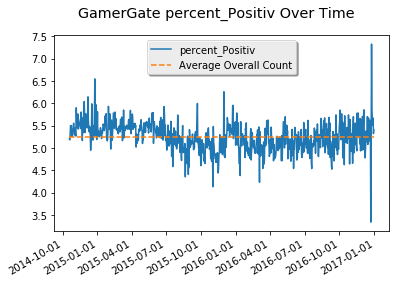

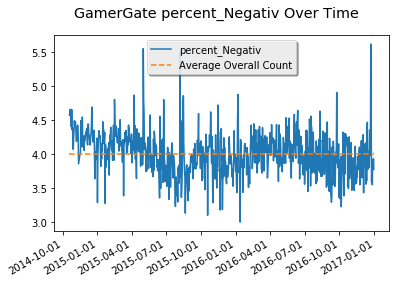

In [73]:
# Save over the columns we want
CategoryTweetGraphFrame = CategoryTweetFrame[["count_tokens","Positiv","Negativ"]].copy()

# Calulate percent of Positiv and Negativ when compared to total amount of tokens that day
# This is done by dividing the category amount with total amount of tweet (*100 to get a percent)
CategoryTweetGraphFrame["percent_Positiv"] = (CategoryTweetGraphFrame["Positiv"] / CategoryTweetGraphFrame["count_tokens"]) * 100
CategoryTweetGraphFrame["percent_Negativ"] = (CategoryTweetGraphFrame["Negativ"] / CategoryTweetGraphFrame["count_tokens"]) * 100

# Plotting both the postive and negative category percentage
for columns in CategoryTweetGraphFrame[["percent_Positiv", "percent_Negativ"]]:
    basic_plot_generator(columns, CategoryTweetGraphFrame.index, CategoryTweetGraphFrame, intervalValue= 3)

# Plotting Different LIWC Category Against Eachother

Now that we have the values in each category. We can plot different categories against eachother

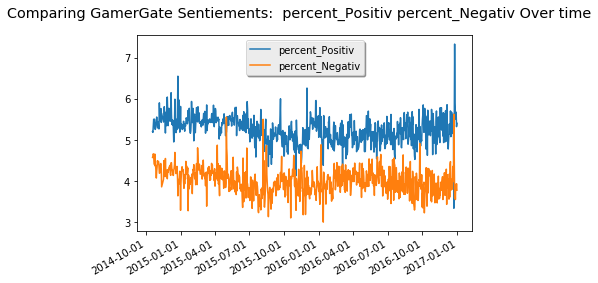

In [74]:
# Ploting Negativ and Postiv against one another in the same graph
plot_compare_generator(['percent_Positiv', 'percent_Negativ'], CategoryTweetGraphFrame.index, CategoryTweetGraphFrame, intervalValue= 3, saveImage=True, fileName="Pos_Neg_Compare")

# Conclusion

In this IPython Notebook we went over a wide varity of data manipulation and analysis. From tokenizing the text, word count, extracting hashtag and finally LIWC. 

This IPython Notebook provides a foundation for future research. It also written in a modular format to allow for easy code modification to adapt this IPython Notebook to fit other datasets. Although some aspect are exclusive to the example dataset (column names), all the functionality had been purposely made generic to be transferable for other use (MasterTweetFrame is a generic name). 